# Convolutional AE on MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
from tensorflow.keras import layers, losses

import warnings
warnings.filterwarnings('ignore')

2022-06-29 18:37:54.101284: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-29 18:37:54.101315: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-29 18:37:55.256092: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-29 18:37:55.256115: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-29 18:37:55.256128: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-06-29 18:37:55.256320: I tensorflow/core/platform/cpu_fe

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0

In [3]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


In [4]:
num_data, input_dim_x, input_dim_y = x_train.shape
input_dim = input_dim_x, input_dim_y
input_dim

(28, 28)

In [5]:
latent_dim = 1
ae = cae.Convolutional_Autoencoder(input_dim)

In [6]:
ae.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.1))

In [7]:
ae.build(x_train.shape)
ae.summary()

Model: "convolutional__autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 7, 7, 1)           609       
                                                                 
 sequential_1 (Sequential)   (12049, 28, 28, 1)        2591      
                                                                 
Total params: 3,200
Trainable params: 3,200
Non-trainable params: 0
_________________________________________________________________


Summary of encoder and decoder model

In [8]:
ae.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 1)           289       
                                                                 
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


In [9]:
ae.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (12049, 14, 14, 3)       30        
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (12049, 28, 28, 32)      2432      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (12049, 28, 28, 1)        129       
                                                                 
Total params: 2,591
Trainable params: 2,591
Non-trainable params: 0
_________________________________________________________________


In [10]:
x_train_three = x_train[y_train==1]
x_train = x_train[y_train==0]

x_test_three = x_test[y_test==1]
x_test = x_test[y_test==0]

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
hist = ae.fit(x_train, x_train,
                epochs=40,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[es])

Epoch 1/40
185/185 [==============================] - 4s 21ms/step - loss: 0.0389 - val_loss: 0.0192
Epoch 2/40
185/185 [==============================] - 3s 19ms/step - loss: 0.0182 - val_loss: 0.0170
Epoch 3/40
185/185 [==============================] - 4s 20ms/step - loss: 0.0174 - val_loss: 0.0167
Epoch 4/40
185/185 [==============================] - 4s 23ms/step - loss: 0.0165 - val_loss: 0.0170
Epoch 5/40
185/185 [==============================] - 3s 16ms/step - loss: 0.0161 - val_loss: 0.0161
Epoch 6/40
185/185 [==============================] - 4s 21ms/step - loss: 0.0160 - val_loss: 0.0159
Epoch 7/40
185/185 [==============================] - 4s 21ms/step - loss: 0.0160 - val_loss: 0.0155
Epoch 8/40
185/185 [==============================] - 4s 20ms/step - loss: 0.0155 - val_loss: 0.0149
Epoch 9/40
185/185 [==============================] - 4s 20ms/step - loss: 0.0154 - val_loss: 0.0173
Epoch 10/40
185/185 [==============================] - 4s 21ms/step - loss: 0.0151 - val_lo

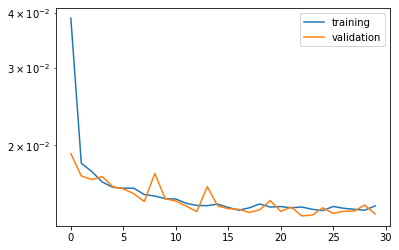

In [12]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['val_loss'], label="validation")
plt.yscale('log')
plt.legend()

In [13]:
def mae(x):
    pred = ae.predict(x)
    pred = pred.reshape(pred.shape[:-1])
    return np.mean(np.abs(x - pred)**2,axis=(1,2))

def recon_acc(x):
    return 1 - mae(x)

In [14]:
sixes = recon_acc(x_test)
threes = recon_acc(x_test_three)

0.9873699599022376
0.9705602500428376


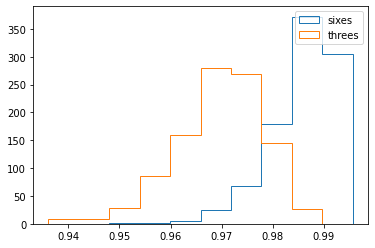

In [15]:
print(np.median(sixes))
bins = np.histogram(np.hstack((sixes, threes)), bins=10)[1]
plt.hist(sixes, histtype='step', label="sixes",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
print(np.median(threes))
plt.hist(threes, histtype='step', label="threes",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
plt.legend()

0.8765243902439024


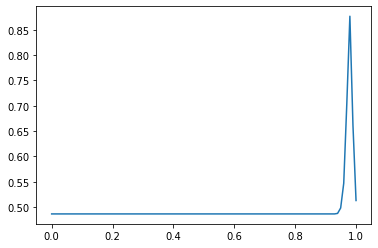

In [16]:
def acc_for_threshold(T):
    # sixes that are predicted six
    num_six_right = np.sum(sixes > T)
    # threes that are predicted three
    num_three_right = np.sum(threes < T)
    acc = (num_six_right + num_three_right)/(len(sixes) + len(threes))
    return acc

Ts = np.linspace(0,1,100)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
print(max(accs))
plt.plot(Ts, accs)  